# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()


In [5]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
def load_model(weights =models.ResNet152_Weights.IMAGENET1K_V2):
    weights = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2
    model = models.resnext101_32x8d(weights=weights)
    transforms = weights.transforms()
    size_parameters = 512
    model.fc = nn.Sequential(
        #nn.Linear(model.fc.in_features, size_parameters),
        #nn.ReLU(),
        #nn.Linear(size_parameters, size_parameters),
        #nn.ReLU(),
        #nn.Linear(size_parameters, size_parameters),
        #nn.ReLU(),
        nn.Linear(model.fc.in_features, 832), # 13 pieces types 8*8*13
        nn.Sigmoid()
    )
    # black 
    model.to(device)
    return model,transforms
model, transforms1 = load_model()

Using cuda device


In [7]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [8]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.zeros((len(self.file_names), 8,8, 13), dtype=torch.float32)
        for i in range(8):
            for j in range(8):
                self.boards[:, i, j, 12] = 1 # initialize empty board with 1s for empty squares
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row][col][12] =0
            self.boards[idx][row][col][piceId] =1
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board




In [ ]:
train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)

Number of train images: 6479
Number of valid images: 2192


In [ ]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
['K', '-', '-', 'Q', '-', '-', 'R', '-']
['-', 'P', '-', '-', '-', '-', '-', '-']
['P', '-', 'P', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'p', '-', '-', 'P']
['-', 'B', 'p', 'p', '-', '-', '-', '-']
['-', 'p', '-', 'q', '-', '-', 'n', '-']
['p', 'b', '-', '-', 'r', '-', 'p', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


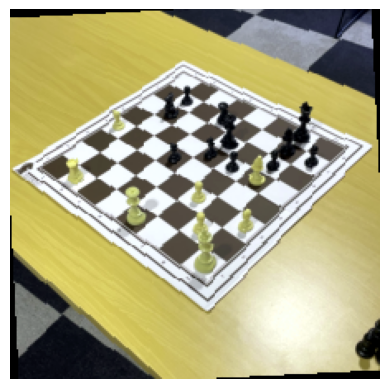

In [ ]:
def convert_to_redable(labels):
    result = []
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(int(torch.argmax(labels[i][j])))
        result.append(result_tmp)
    return result
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(piece_dict[int(torch.argmax(labels[i][j]))])
        print(result_tmp)


for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)
    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break


## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    all_preds = all_preds.argmax(dim=-1)
    all_labels = all_labels.argmax(dim=-1)
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    recall1 = recall_score(all_labels.flatten(), all_preds.flatten(), average='micro')
    precision1 = precision_score(all_labels.flatten(), all_preds.flatten(), average='micro')
    f11 = f1_score(all_labels.flatten(), all_preds.flatten(), average='micro')
    print(f"Micro: Recall: {recall1:.4f}, Precision: {precision1:.4f}, F1: {f11:.4f}")
    return accuracy, recall, precision, f1
def claculateMissMatchs(all_preds, all_labels):
    all_preds = all_preds.argmax(dim=-1)
    all_labels = all_labels.argmax(dim=-1)
    accuracyList = np.zeros(64, dtype=int)
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      missmatched =total- correct
      accuracyList[missmatched] += 1
    return accuracyList

## Train the model

Define function to perform one iteration

In [ ]:

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          batch_size = X.size(0)
          formated_pred = pred.view(batch_size, 8, 8, 13)
          #scaled_pred = model(X)
          #print("Test",formated_pred.shape,y.shape)
          #print(fomated_pred,y)
          loss = loss_fn(formated_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.append(formated_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds)
    all_labels = torch.cat(labels)
    # compute the predictions and labels:
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Accuracy:", accuracy)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [ ]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [ ]:
# Define loss function
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 404/404 [02:12<00:00,  3.04it/s]


Train loss: 1.15310 	 Train acc: 0.00000 	 Train recall: 0.45258 	 Train precision: 0.22452 	 Train f1: 0.24433


100%|██████████| 137/137 [00:14<00:00,  9.61it/s]


Val loss: 1.16638 	 Val acc: 0.00000 	 Val recall: 0.45603 	 Val precision: 0.21756 	 Val f1: 0.23881

Epoch 2


100%|██████████| 404/404 [02:10<00:00,  3.08it/s]


Train loss: 1.12195 	 Train acc: 0.00000 	 Train recall: 0.50655 	 Train precision: 0.25301 	 Train f1: 0.28840


100%|██████████| 137/137 [00:14<00:00,  9.63it/s]


Val loss: 1.15291 	 Val acc: 0.00000 	 Val recall: 0.42791 	 Val precision: 0.21707 	 Val f1: 0.24176

Epoch 3


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 1.09621 	 Train acc: 0.00000 	 Train recall: 0.53401 	 Train precision: 0.27531 	 Train f1: 0.31823


100%|██████████| 137/137 [00:14<00:00,  9.63it/s]


Val loss: 1.13842 	 Val acc: 0.00000 	 Val recall: 0.44964 	 Val precision: 0.23416 	 Val f1: 0.26350

Epoch 4


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 1.07596 	 Train acc: 0.00000 	 Train recall: 0.56280 	 Train precision: 0.30029 	 Train f1: 0.35084


100%|██████████| 137/137 [00:14<00:00,  9.58it/s]


Val loss: 1.12298 	 Val acc: 0.00000 	 Val recall: 0.42399 	 Val precision: 0.24149 	 Val f1: 0.27236

Epoch 5


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 1.06208 	 Train acc: 0.00000 	 Train recall: 0.57621 	 Train precision: 0.31908 	 Train f1: 0.37430


100%|██████████| 137/137 [00:14<00:00,  9.55it/s]


Val loss: 1.10819 	 Val acc: 0.00000 	 Val recall: 0.44937 	 Val precision: 0.26094 	 Val f1: 0.29933

Epoch 6


100%|██████████| 404/404 [02:09<00:00,  3.11it/s]


Train loss: 1.05339 	 Train acc: 0.00000 	 Train recall: 0.61125 	 Train precision: 0.35234 	 Train f1: 0.41695


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.10108 	 Val acc: 0.00000 	 Val recall: 0.48214 	 Val precision: 0.28775 	 Val f1: 0.33322

Epoch 7


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04853 	 Train acc: 0.00000 	 Train recall: 0.63300 	 Train precision: 0.37593 	 Train f1: 0.44445


100%|██████████| 137/137 [00:14<00:00,  9.74it/s]


Val loss: 1.09425 	 Val acc: 0.00000 	 Val recall: 0.47610 	 Val precision: 0.29241 	 Val f1: 0.33760

Epoch 8


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04630 	 Train acc: 0.00000 	 Train recall: 0.63923 	 Train precision: 0.38910 	 Train f1: 0.45960


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.09374 	 Val acc: 0.00000 	 Val recall: 0.47920 	 Val precision: 0.29842 	 Val f1: 0.34585

Epoch 9


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04567 	 Train acc: 0.00000 	 Train recall: 0.63924 	 Train precision: 0.39689 	 Train f1: 0.46716


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.08972 	 Val acc: 0.00000 	 Val recall: 0.49624 	 Val precision: 0.30794 	 Val f1: 0.35911

Epoch 10


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04473 	 Train acc: 0.00000 	 Train recall: 0.64620 	 Train precision: 0.40675 	 Train f1: 0.47784


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.09129 	 Val acc: 0.00000 	 Val recall: 0.49079 	 Val precision: 0.31053 	 Val f1: 0.36112

Epoch 11


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04431 	 Train acc: 0.00000 	 Train recall: 0.65871 	 Train precision: 0.41967 	 Train f1: 0.49195


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 1.09008 	 Val acc: 0.00000 	 Val recall: 0.49929 	 Val precision: 0.31904 	 Val f1: 0.37032

Epoch 12


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04388 	 Train acc: 0.00000 	 Train recall: 0.66633 	 Train precision: 0.42707 	 Train f1: 0.50081


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.08968 	 Val acc: 0.00000 	 Val recall: 0.49381 	 Val precision: 0.31455 	 Val f1: 0.36553

Epoch 13


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04377 	 Train acc: 0.00000 	 Train recall: 0.67617 	 Train precision: 0.45025 	 Train f1: 0.52113


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 1.08999 	 Val acc: 0.00000 	 Val recall: 0.49318 	 Val precision: 0.32630 	 Val f1: 0.37608

Epoch 14


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04340 	 Train acc: 0.00000 	 Train recall: 0.68394 	 Train precision: 0.46806 	 Train f1: 0.53733


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.08859 	 Val acc: 0.00000 	 Val recall: 0.49086 	 Val precision: 0.33177 	 Val f1: 0.38060

Epoch 15


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04303 	 Train acc: 0.00000 	 Train recall: 0.68824 	 Train precision: 0.47047 	 Train f1: 0.54254


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.09033 	 Val acc: 0.00000 	 Val recall: 0.49706 	 Val precision: 0.32871 	 Val f1: 0.37942

Epoch 16


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04292 	 Train acc: 0.00000 	 Train recall: 0.69510 	 Train precision: 0.48539 	 Train f1: 0.55566


100%|██████████| 137/137 [00:14<00:00,  9.70it/s]


Val loss: 1.08888 	 Val acc: 0.00000 	 Val recall: 0.49328 	 Val precision: 0.33854 	 Val f1: 0.38681

Epoch 17


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04243 	 Train acc: 0.00000 	 Train recall: 0.69704 	 Train precision: 0.50237 	 Train f1: 0.56761


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.08894 	 Val acc: 0.00000 	 Val recall: 0.51634 	 Val precision: 0.36552 	 Val f1: 0.41520

Epoch 18


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04199 	 Train acc: 0.00000 	 Train recall: 0.70937 	 Train precision: 0.53239 	 Train f1: 0.59197


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 1.08917 	 Val acc: 0.00000 	 Val recall: 0.51295 	 Val precision: 0.38216 	 Val f1: 0.42681

Epoch 19


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 1.04155 	 Train acc: 0.00000 	 Train recall: 0.71180 	 Train precision: 0.54134 	 Train f1: 0.59983


100%|██████████| 137/137 [00:14<00:00,  9.70it/s]


Val loss: 1.08713 	 Val acc: 0.00000 	 Val recall: 0.51263 	 Val precision: 0.37025 	 Val f1: 0.41737

Epoch 20


100%|██████████| 404/404 [02:09<00:00,  3.12it/s]


Train loss: 1.04120 	 Train acc: 0.00000 	 Train recall: 0.71793 	 Train precision: 0.53929 	 Train f1: 0.60295


100%|██████████| 137/137 [00:14<00:00,  9.76it/s]


Val loss: 1.09094 	 Val acc: 0.00000 	 Val recall: 0.49815 	 Val precision: 0.36790 	 Val f1: 0.40901

Epoch 21


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03986 	 Train acc: 0.00000 	 Train recall: 0.74510 	 Train precision: 0.56507 	 Train f1: 0.62843


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


Val loss: 1.08607 	 Val acc: 0.00000 	 Val recall: 0.51794 	 Val precision: 0.39983 	 Val f1: 0.43529

Epoch 22


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03803 	 Train acc: 0.00000 	 Train recall: 0.75597 	 Train precision: 0.59609 	 Train f1: 0.65324


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]


Val loss: 1.08456 	 Val acc: 0.00000 	 Val recall: 0.52491 	 Val precision: 0.41974 	 Val f1: 0.45255

Epoch 23


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03765 	 Train acc: 0.00015 	 Train recall: 0.76257 	 Train precision: 0.61214 	 Train f1: 0.66587


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]


Val loss: 1.08505 	 Val acc: 0.00000 	 Val recall: 0.54422 	 Val precision: 0.42664 	 Val f1: 0.46468

Epoch 24


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03741 	 Train acc: 0.00000 	 Train recall: 0.76647 	 Train precision: 0.61610 	 Train f1: 0.67032


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]


Val loss: 1.08804 	 Val acc: 0.00000 	 Val recall: 0.53025 	 Val precision: 0.41615 	 Val f1: 0.45188

Epoch 25


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03766 	 Train acc: 0.00015 	 Train recall: 0.76259 	 Train precision: 0.61798 	 Train f1: 0.67067


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


Val loss: 1.08458 	 Val acc: 0.00000 	 Val recall: 0.53259 	 Val precision: 0.42393 	 Val f1: 0.45998

Epoch 26


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03722 	 Train acc: 0.00046 	 Train recall: 0.76605 	 Train precision: 0.62920 	 Train f1: 0.67873


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


Val loss: 1.08551 	 Val acc: 0.00000 	 Val recall: 0.52994 	 Val precision: 0.43090 	 Val f1: 0.46331

Epoch 27


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 1.03680 	 Train acc: 0.00062 	 Train recall: 0.76607 	 Train precision: 0.64031 	 Train f1: 0.68485


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


Val loss: 1.08444 	 Val acc: 0.00000 	 Val recall: 0.53493 	 Val precision: 0.43488 	 Val f1: 0.46769

Epoch 28


100%|██████████| 404/404 [02:15<00:00,  2.97it/s]


Train loss: 1.03675 	 Train acc: 0.00015 	 Train recall: 0.76524 	 Train precision: 0.63572 	 Train f1: 0.68281


100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


Val loss: 1.08618 	 Val acc: 0.00000 	 Val recall: 0.53048 	 Val precision: 0.43429 	 Val f1: 0.46540

Epoch 29


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03666 	 Train acc: 0.00015 	 Train recall: 0.76876 	 Train precision: 0.63746 	 Train f1: 0.68572


100%|██████████| 137/137 [00:14<00:00,  9.61it/s]


Val loss: 1.08547 	 Val acc: 0.00000 	 Val recall: 0.52999 	 Val precision: 0.43022 	 Val f1: 0.46329

Epoch 30


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03664 	 Train acc: 0.00031 	 Train recall: 0.76603 	 Train precision: 0.64236 	 Train f1: 0.68818


100%|██████████| 137/137 [00:14<00:00,  9.64it/s]


Val loss: 1.08535 	 Val acc: 0.00000 	 Val recall: 0.51651 	 Val precision: 0.42378 	 Val f1: 0.45508

Epoch 31


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03647 	 Train acc: 0.00155 	 Train recall: 0.77482 	 Train precision: 0.65475 	 Train f1: 0.70144


100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


Val loss: 1.08365 	 Val acc: 0.00000 	 Val recall: 0.54194 	 Val precision: 0.44698 	 Val f1: 0.47920

Epoch 32


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 1.03626 	 Train acc: 0.00093 	 Train recall: 0.77361 	 Train precision: 0.65974 	 Train f1: 0.70349


100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


Val loss: 1.08444 	 Val acc: 0.00000 	 Val recall: 0.51848 	 Val precision: 0.43543 	 Val f1: 0.46184

Epoch 33


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03630 	 Train acc: 0.00155 	 Train recall: 0.77894 	 Train precision: 0.66992 	 Train f1: 0.71180


100%|██████████| 137/137 [00:14<00:00,  9.62it/s]


Val loss: 1.08507 	 Val acc: 0.00000 	 Val recall: 0.54360 	 Val precision: 0.46525 	 Val f1: 0.49352

Epoch 34


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03616 	 Train acc: 0.00186 	 Train recall: 0.78478 	 Train precision: 0.68454 	 Train f1: 0.72378


100%|██████████| 137/137 [00:14<00:00,  9.63it/s]


Val loss: 1.08442 	 Val acc: 0.00000 	 Val recall: 0.54731 	 Val precision: 0.46156 	 Val f1: 0.49240

Epoch 35


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03609 	 Train acc: 0.00356 	 Train recall: 0.78061 	 Train precision: 0.68126 	 Train f1: 0.72049


100%|██████████| 137/137 [00:14<00:00,  9.60it/s]


Val loss: 1.08455 	 Val acc: 0.00000 	 Val recall: 0.55252 	 Val precision: 0.47310 	 Val f1: 0.50137

Epoch 36


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03616 	 Train acc: 0.00603 	 Train recall: 0.78574 	 Train precision: 0.69159 	 Train f1: 0.72911


100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


Val loss: 1.08523 	 Val acc: 0.00000 	 Val recall: 0.54726 	 Val precision: 0.46028 	 Val f1: 0.49135

Epoch 37


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03633 	 Train acc: 0.00340 	 Train recall: 0.77914 	 Train precision: 0.67765 	 Train f1: 0.71748


100%|██████████| 137/137 [00:14<00:00,  9.66it/s]


Val loss: 1.08497 	 Val acc: 0.00000 	 Val recall: 0.53697 	 Val precision: 0.45894 	 Val f1: 0.48644

Epoch 38


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03594 	 Train acc: 0.00418 	 Train recall: 0.78032 	 Train precision: 0.69146 	 Train f1: 0.72536


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 1.08413 	 Val acc: 0.00000 	 Val recall: 0.53893 	 Val precision: 0.46621 	 Val f1: 0.49168

Epoch 39


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03588 	 Train acc: 0.00634 	 Train recall: 0.78961 	 Train precision: 0.70588 	 Train f1: 0.73757


100%|██████████| 137/137 [00:14<00:00,  9.67it/s]


Val loss: 1.08378 	 Val acc: 0.00000 	 Val recall: 0.55499 	 Val precision: 0.47986 	 Val f1: 0.50564

Epoch 40


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]


Train loss: 1.03602 	 Train acc: 0.00495 	 Train recall: 0.79043 	 Train precision: 0.70291 	 Train f1: 0.73561


100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


Val loss: 1.08474 	 Val acc: 0.00000 	 Val recall: 0.54260 	 Val precision: 0.46986 	 Val f1: 0.49496

Epoch 41


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03576 	 Train acc: 0.00526 	 Train recall: 0.79296 	 Train precision: 0.71125 	 Train f1: 0.74201


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]


Val loss: 1.08401 	 Val acc: 0.00000 	 Val recall: 0.53764 	 Val precision: 0.46380 	 Val f1: 0.48804

Epoch 42


100%|██████████| 404/404 [02:15<00:00,  2.98it/s]


Train loss: 1.03560 	 Train acc: 0.00696 	 Train recall: 0.78836 	 Train precision: 0.71232 	 Train f1: 0.74052


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


Val loss: 1.08364 	 Val acc: 0.00000 	 Val recall: 0.54542 	 Val precision: 0.47066 	 Val f1: 0.49673

Epoch 43


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 1.03573 	 Train acc: 0.00727 	 Train recall: 0.79232 	 Train precision: 0.71547 	 Train f1: 0.74440


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 1.08401 	 Val acc: 0.00000 	 Val recall: 0.53697 	 Val precision: 0.47040 	 Val f1: 0.49256

Epoch 44


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 1.03577 	 Train acc: 0.00402 	 Train recall: 0.78507 	 Train precision: 0.71051 	 Train f1: 0.73794


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 1.08506 	 Val acc: 0.00000 	 Val recall: 0.52985 	 Val precision: 0.45739 	 Val f1: 0.48158

Epoch 45


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03595 	 Train acc: 0.00480 	 Train recall: 0.78113 	 Train precision: 0.69586 	 Train f1: 0.72848


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]


Val loss: 1.08399 	 Val acc: 0.00000 	 Val recall: 0.54958 	 Val precision: 0.47176 	 Val f1: 0.49802

Epoch 46


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03571 	 Train acc: 0.00665 	 Train recall: 0.79438 	 Train precision: 0.71058 	 Train f1: 0.74264


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08476 	 Val acc: 0.00000 	 Val recall: 0.54858 	 Val precision: 0.47447 	 Val f1: 0.49954

Epoch 47


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03577 	 Train acc: 0.01207 	 Train recall: 0.79979 	 Train precision: 0.71905 	 Train f1: 0.75078


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08359 	 Val acc: 0.00000 	 Val recall: 0.54531 	 Val precision: 0.47527 	 Val f1: 0.49967

Epoch 48


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03550 	 Train acc: 0.02584 	 Train recall: 0.80046 	 Train precision: 0.73908 	 Train f1: 0.76344


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


Val loss: 1.08507 	 Val acc: 0.00000 	 Val recall: 0.54203 	 Val precision: 0.48415 	 Val f1: 0.50447

Epoch 49


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03540 	 Train acc: 0.02228 	 Train recall: 0.79448 	 Train precision: 0.73668 	 Train f1: 0.75919


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08384 	 Val acc: 0.00000 	 Val recall: 0.54276 	 Val precision: 0.48782 	 Val f1: 0.50762

Epoch 50


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03538 	 Train acc: 0.02274 	 Train recall: 0.79306 	 Train precision: 0.73547 	 Train f1: 0.75798


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08393 	 Val acc: 0.00000 	 Val recall: 0.53793 	 Val precision: 0.48408 	 Val f1: 0.50358

Epoch 51


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03528 	 Train acc: 0.02816 	 Train recall: 0.79336 	 Train precision: 0.73971 	 Train f1: 0.75983


100%|██████████| 137/137 [00:14<00:00,  9.24it/s]


Val loss: 1.08389 	 Val acc: 0.00000 	 Val recall: 0.52957 	 Val precision: 0.46942 	 Val f1: 0.49104

Epoch 52


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03547 	 Train acc: 0.02228 	 Train recall: 0.78792 	 Train precision: 0.72986 	 Train f1: 0.75198


100%|██████████| 137/137 [00:14<00:00,  9.20it/s]


Val loss: 1.08447 	 Val acc: 0.00000 	 Val recall: 0.53755 	 Val precision: 0.47607 	 Val f1: 0.49744

Epoch 53


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03554 	 Train acc: 0.01810 	 Train recall: 0.79262 	 Train precision: 0.72862 	 Train f1: 0.75473


100%|██████████| 137/137 [00:14<00:00,  9.24it/s]


Val loss: 1.08453 	 Val acc: 0.00000 	 Val recall: 0.53564 	 Val precision: 0.46444 	 Val f1: 0.49214

Epoch 54


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 1.03541 	 Train acc: 0.02305 	 Train recall: 0.79397 	 Train precision: 0.73369 	 Train f1: 0.75784


100%|██████████| 137/137 [00:14<00:00,  9.28it/s]


Val loss: 1.08396 	 Val acc: 0.00000 	 Val recall: 0.53456 	 Val precision: 0.47572 	 Val f1: 0.49739

Epoch 55


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03519 	 Train acc: 0.02382 	 Train recall: 0.78443 	 Train precision: 0.73126 	 Train f1: 0.75155


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


Val loss: 1.08303 	 Val acc: 0.00000 	 Val recall: 0.53262 	 Val precision: 0.48241 	 Val f1: 0.50028

Epoch 56


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03517 	 Train acc: 0.03001 	 Train recall: 0.78618 	 Train precision: 0.74111 	 Train f1: 0.75706


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


Val loss: 1.08255 	 Val acc: 0.00000 	 Val recall: 0.52929 	 Val precision: 0.47094 	 Val f1: 0.49267

Epoch 57


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03532 	 Train acc: 0.02150 	 Train recall: 0.78350 	 Train precision: 0.72610 	 Train f1: 0.74854


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]


Val loss: 1.08403 	 Val acc: 0.00046 	 Val recall: 0.52798 	 Val precision: 0.47429 	 Val f1: 0.49237

Epoch 58


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 1.03526 	 Train acc: 0.02336 	 Train recall: 0.78401 	 Train precision: 0.73251 	 Train f1: 0.75120


100%|██████████| 137/137 [00:14<00:00,  9.20it/s]


Val loss: 1.08343 	 Val acc: 0.00046 	 Val recall: 0.53237 	 Val precision: 0.47406 	 Val f1: 0.49533

Epoch 59


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03514 	 Train acc: 0.02042 	 Train recall: 0.78714 	 Train precision: 0.73763 	 Train f1: 0.75550


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08436 	 Val acc: 0.00000 	 Val recall: 0.54017 	 Val precision: 0.47773 	 Val f1: 0.49978

Epoch 60


100%|██████████| 404/404 [02:16<00:00,  2.97it/s]


Train loss: 1.03527 	 Train acc: 0.01903 	 Train recall: 0.78699 	 Train precision: 0.73547 	 Train f1: 0.75497


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]


Val loss: 1.08361 	 Val acc: 0.00000 	 Val recall: 0.53542 	 Val precision: 0.48031 	 Val f1: 0.49999

Epoch 61


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03528 	 Train acc: 0.01980 	 Train recall: 0.79053 	 Train precision: 0.74352 	 Train f1: 0.76042


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]


Val loss: 1.08333 	 Val acc: 0.00046 	 Val recall: 0.54391 	 Val precision: 0.48756 	 Val f1: 0.50692

Epoch 62


100%|██████████| 404/404 [02:16<00:00,  2.97it/s]


Train loss: 1.03516 	 Train acc: 0.02382 	 Train recall: 0.79353 	 Train precision: 0.74645 	 Train f1: 0.76330


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 1.08350 	 Val acc: 0.00000 	 Val recall: 0.53655 	 Val precision: 0.48023 	 Val f1: 0.50036

Epoch 63


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03500 	 Train acc: 0.02537 	 Train recall: 0.79253 	 Train precision: 0.75238 	 Train f1: 0.76550


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 1.08383 	 Val acc: 0.00000 	 Val recall: 0.53935 	 Val precision: 0.48433 	 Val f1: 0.50396

Epoch 64


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03503 	 Train acc: 0.02599 	 Train recall: 0.79715 	 Train precision: 0.75645 	 Train f1: 0.77047


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 1.08351 	 Val acc: 0.00000 	 Val recall: 0.52710 	 Val precision: 0.46889 	 Val f1: 0.48879

Epoch 65


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03515 	 Train acc: 0.02522 	 Train recall: 0.78666 	 Train precision: 0.74872 	 Train f1: 0.76044


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


Val loss: 1.08370 	 Val acc: 0.00000 	 Val recall: 0.53293 	 Val precision: 0.47861 	 Val f1: 0.49799

Epoch 66


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 1.03511 	 Train acc: 0.02955 	 Train recall: 0.79442 	 Train precision: 0.75193 	 Train f1: 0.76662


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]


Val loss: 1.08360 	 Val acc: 0.00000 	 Val recall: 0.54430 	 Val precision: 0.48163 	 Val f1: 0.50373

Epoch 67


100%|██████████| 404/404 [02:15<00:00,  2.97it/s]


Train loss: 1.03521 	 Train acc: 0.02382 	 Train recall: 0.79160 	 Train precision: 0.74807 	 Train f1: 0.76332


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


Val loss: 1.08327 	 Val acc: 0.00000 	 Val recall: 0.53068 	 Val precision: 0.47537 	 Val f1: 0.49501

Epoch 68


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03514 	 Train acc: 0.02413 	 Train recall: 0.78957 	 Train precision: 0.73941 	 Train f1: 0.75800


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


Val loss: 1.08329 	 Val acc: 0.00000 	 Val recall: 0.54486 	 Val precision: 0.49035 	 Val f1: 0.50973

Epoch 69


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03515 	 Train acc: 0.02491 	 Train recall: 0.79382 	 Train precision: 0.75177 	 Train f1: 0.76694


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 1.08348 	 Val acc: 0.00000 	 Val recall: 0.53524 	 Val precision: 0.47175 	 Val f1: 0.49520

Epoch 70


100%|██████████| 404/404 [02:15<00:00,  2.97it/s]


Train loss: 1.03495 	 Train acc: 0.02676 	 Train recall: 0.78554 	 Train precision: 0.74940 	 Train f1: 0.76040


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 1.08224 	 Val acc: 0.00000 	 Val recall: 0.54242 	 Val precision: 0.48896 	 Val f1: 0.50796

Epoch 71


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03497 	 Train acc: 0.02924 	 Train recall: 0.79494 	 Train precision: 0.76441 	 Train f1: 0.77339


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


Val loss: 1.08250 	 Val acc: 0.00000 	 Val recall: 0.54523 	 Val precision: 0.48736 	 Val f1: 0.50733

Epoch 72


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03503 	 Train acc: 0.03202 	 Train recall: 0.79368 	 Train precision: 0.76240 	 Train f1: 0.77172


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


Val loss: 1.08265 	 Val acc: 0.00000 	 Val recall: 0.51436 	 Val precision: 0.47302 	 Val f1: 0.48620

Epoch 73


100%|██████████| 404/404 [02:15<00:00,  2.98it/s]


Train loss: 1.03513 	 Train acc: 0.02707 	 Train recall: 0.78423 	 Train precision: 0.75293 	 Train f1: 0.76214


100%|██████████| 137/137 [00:14<00:00,  9.20it/s]


Val loss: 1.08423 	 Val acc: 0.00000 	 Val recall: 0.53525 	 Val precision: 0.48352 	 Val f1: 0.50117

Epoch 74


100%|██████████| 404/404 [02:15<00:00,  2.98it/s]


Train loss: 1.03511 	 Train acc: 0.02877 	 Train recall: 0.78497 	 Train precision: 0.75562 	 Train f1: 0.76401


100%|██████████| 137/137 [00:14<00:00,  9.25it/s]


Val loss: 1.08357 	 Val acc: 0.00000 	 Val recall: 0.53322 	 Val precision: 0.48771 	 Val f1: 0.50442

Epoch 75


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03496 	 Train acc: 0.02800 	 Train recall: 0.78485 	 Train precision: 0.75529 	 Train f1: 0.76351


100%|██████████| 137/137 [00:14<00:00,  9.34it/s]


Val loss: 1.08378 	 Val acc: 0.00000 	 Val recall: 0.52745 	 Val precision: 0.47794 	 Val f1: 0.49561

Epoch 76


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.03498 	 Train acc: 0.03295 	 Train recall: 0.79199 	 Train precision: 0.75423 	 Train f1: 0.76715


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 1.08378 	 Val acc: 0.00046 	 Val recall: 0.53833 	 Val precision: 0.49174 	 Val f1: 0.50792

Epoch 77


100%|██████████| 404/404 [02:16<00:00,  2.97it/s]


Train loss: 1.03497 	 Train acc: 0.03713 	 Train recall: 0.79321 	 Train precision: 0.77051 	 Train f1: 0.77542


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 1.08344 	 Val acc: 0.00046 	 Val recall: 0.53762 	 Val precision: 0.49291 	 Val f1: 0.50921

Epoch 78


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 1.03491 	 Train acc: 0.03620 	 Train recall: 0.79177 	 Train precision: 0.76422 	 Train f1: 0.77153


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 1.08349 	 Val acc: 0.00046 	 Val recall: 0.53065 	 Val precision: 0.48300 	 Val f1: 0.49969

Epoch 79


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.03491 	 Train acc: 0.03543 	 Train recall: 0.79409 	 Train precision: 0.76482 	 Train f1: 0.77326


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 1.08363 	 Val acc: 0.00000 	 Val recall: 0.54110 	 Val precision: 0.49342 	 Val f1: 0.51012

Epoch 80


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 1.03497 	 Train acc: 0.03697 	 Train recall: 0.79453 	 Train precision: 0.76671 	 Train f1: 0.77440


100%|██████████| 137/137 [00:15<00:00,  8.96it/s]


Val loss: 1.08333 	 Val acc: 0.00000 	 Val recall: 0.53670 	 Val precision: 0.48781 	 Val f1: 0.50526

Epoch 81


100%|██████████| 404/404 [02:13<00:00,  3.02it/s]


Train loss: 1.03494 	 Train acc: 0.03481 	 Train recall: 0.79305 	 Train precision: 0.75818 	 Train f1: 0.76945


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 1.08326 	 Val acc: 0.00000 	 Val recall: 0.53359 	 Val precision: 0.48099 	 Val f1: 0.50019

Epoch 82


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 1.03486 	 Train acc: 0.03094 	 Train recall: 0.78943 	 Train precision: 0.75780 	 Train f1: 0.76668


100%|██████████| 137/137 [00:14<00:00,  9.66it/s]


Val loss: 1.08347 	 Val acc: 0.00000 	 Val recall: 0.53322 	 Val precision: 0.48524 	 Val f1: 0.50198

Epoch 83


100%|██████████| 404/404 [02:20<00:00,  2.87it/s]


Train loss: 1.03485 	 Train acc: 0.03249 	 Train recall: 0.78875 	 Train precision: 0.75919 	 Train f1: 0.76714


100%|██████████| 137/137 [00:15<00:00,  9.03it/s]


Val loss: 1.08279 	 Val acc: 0.00000 	 Val recall: 0.54880 	 Val precision: 0.49882 	 Val f1: 0.51780

Epoch 84


100%|██████████| 404/404 [02:20<00:00,  2.88it/s]


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

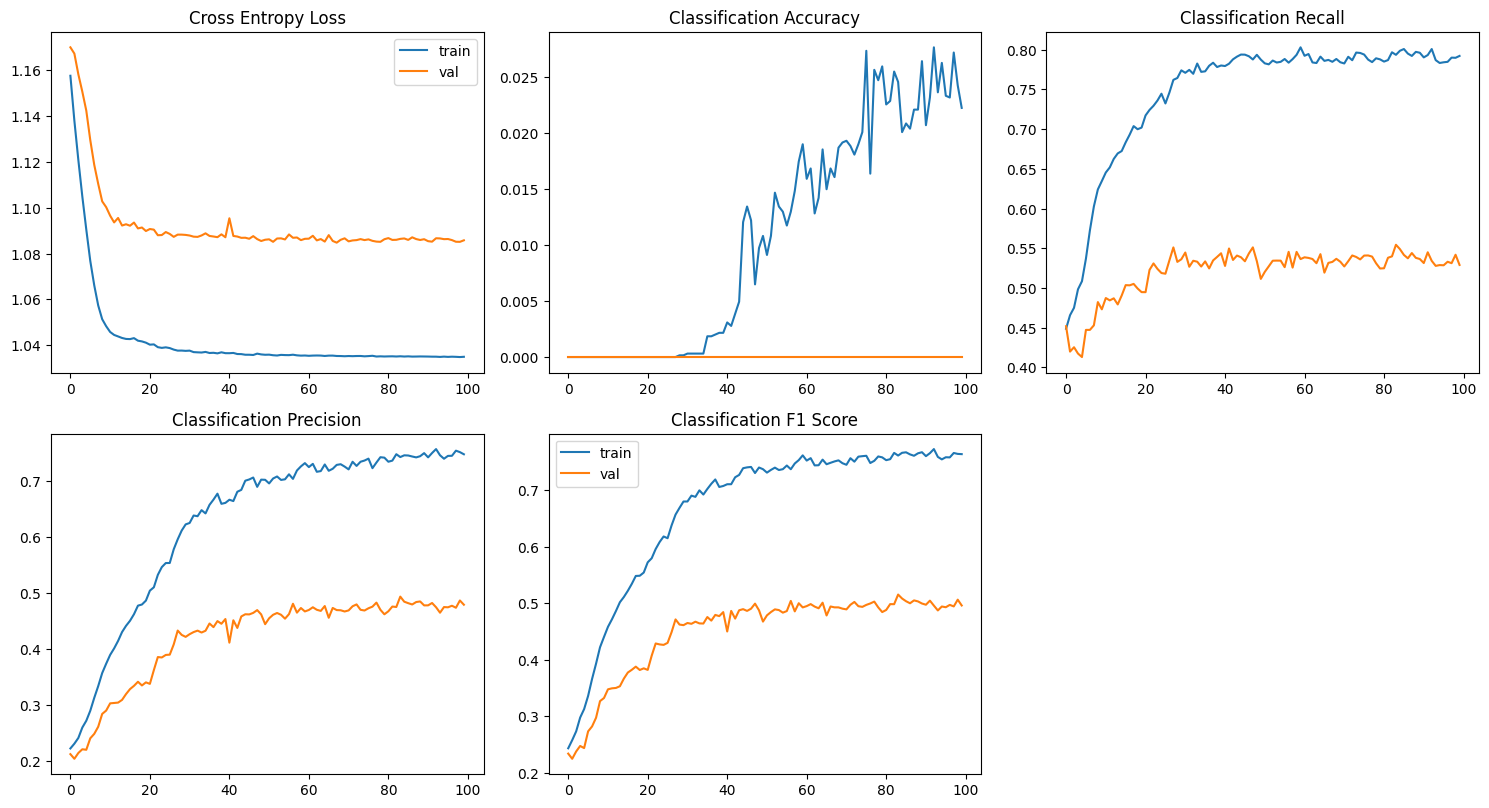

In [ ]:
plotTrainingHistory(train_history, val_history)
del train_history,val_history

## Test the model

Evaluate the model in the test set

In [ ]:
def plot_histogram(arr):
    max_histogram_missmatchs = 20
    arr_filtered = arr[:max_histogram_missmatchs]
    overMaxMissmachs = arr[max_histogram_missmatchs:]
    print("Filtered array:", arr_filtered)
    # Sum the values > max_histogram_missmatchs (if any exist)
    sum_over_16 = overMaxMissmachs.sum() if len(overMaxMissmachs) > 0 else 0

    # Create a new array for plotting (values ≤ 16 + one "16+" bin)
    new_arr = np.append(arr_filtered, sum_over_16)
    indices = np.arange(len(arr_filtered))
    indices = np.append(indices, str(max_histogram_missmatchs)+"+" )  # Add an index for the "16+" bin
    plt.figure(figsize=(8, 6))  # Wider graph (12 inches width, 6 height)
    # Plot the histogram (bar chart)
    plt.bar(indices, new_arr)

    # Add the numbers on top of each bar
    for i, value in enumerate(new_arr):
        if i == len(arr_filtered):
            plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom')
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of Array Values')
    plt.xticks(indices)  # Ensure all indices are shown

    # Display the plot
    plt.show()

In [ ]:
torch.cuda.empty_cache()
#del valid_dataset, valid_dataloader, train_dataset, train_dataloader
test_dataset = ChessDataset('..', 'test', data_in)
batch_size = 16
num_workers = 0 # how many processes are used to load the data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Number of test images: 2129


100%|██████████| 134/134 [00:10<00:00, 12.77it/s]


Test accuracy: tensor([[ 1,  2,  1,  1,  1,  1,  2,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12,  3],
        [12, 12, 12, 12, 12, 12, 12,  8],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  7,  7, 10,  9,  8,  7]])
Missmatchs: [  0   0   1  21  53 125 166 223 285 279 266 219 158 120  82  61  33  20
   9   7   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Missmatchs histogram:
Filtered array: [  0   0   1  21  53 125 166 223 285 279 266 219 158 120  82  61  33  20
   9   7]


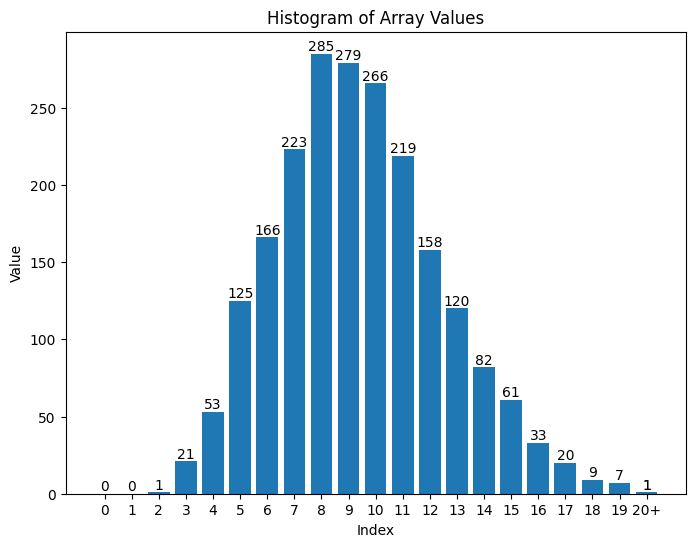

Test accuracy: 0.000, Test recall: 0.537, Test precision: 0.487, Test f1: 0.506


In [ ]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory

#load the best model
#del model
#model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])

def test(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            batch_size = X.size(0)
            formated_pred = pred.view(batch_size, 8, 8, 13)
            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            preds.append(formated_pred.cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        all_preds = torch.cat(preds)
        all_labels = torch.cat(labels)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        print("Test accuracy:", all_preds[0].argmax(dim=-1))
        missmatchs = claculateMissMatchs(all_preds, all_labels)
        print("Missmatchs:", missmatchs)
        print("Missmatchs histogram:")
        plot_histogram(missmatchs)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

  0%|          | 0/134 [00:00<?, ?it/s]

Ground truth: 
['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Prediction: 
['R', 'N', 'R', 'R', 'R', 'R', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', 'B']
['-', '-', '-', '-', '-', '-', '-', 'n']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'r', 'r', 'q', 'b', 'n', 'r']


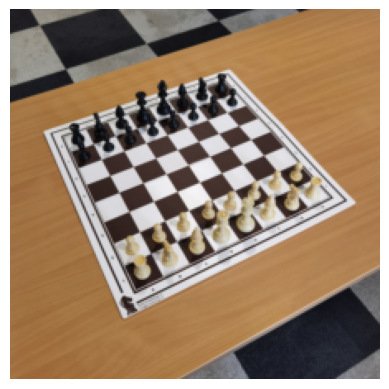

  1%|          | 1/134 [00:00<00:40,  3.25it/s]

Ground truth: 
['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Prediction: 
['R', '-', 'R', 'K', 'R', 'K', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', 'P', '-']
['-', '-', 'Q', '-', '-', 'Q', '-', 'P']
['-', '-', '-', '-', 'P', 'P', '-', 'Q']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'k', 'n', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', 'k', 'r', 'r', 'q', '-', '-', 'r']


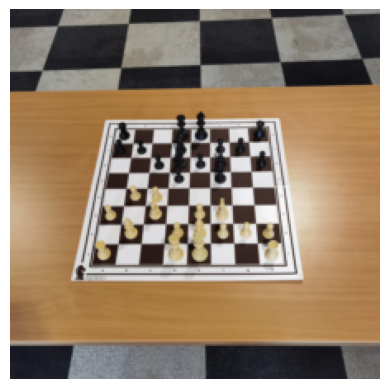

  1%|▏         | 2/134 [00:00<00:31,  4.20it/s]

Ground truth: 
['-', '-', '-', 'R', '-', '-', '-', 'R']
['K', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', 'n', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Prediction: 
['R', '-', 'R', 'K', '-', '-', '-', 'K']
['P', 'B', 'P', '-', 'K', '-', 'B', '-']
['-', 'P', '-', 'P', 'b', 'N', '-', 'P']
['-', 'P', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['q', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'q', '-', 'p', '-']
['r', 'k', '-', 'r', '-', '-', '-', 'r']


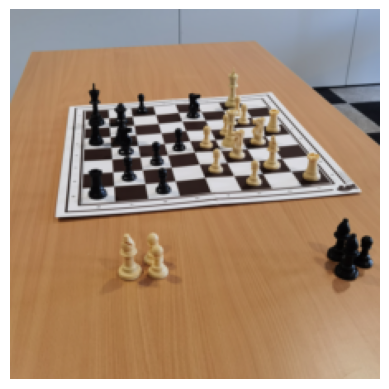

  2%|▏         | 3/134 [00:00<00:27,  4.83it/s]

Ground truth: 
['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', '-', '-', 'n', '-']
['-', 'K', 'N', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'p', 'P', 'p', '-']
['p', '-', '-', 'r', '-', 'p', '-', 'p']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', 'r']
Prediction: 
['-', '-', 'R', 'R', '-', '-', '-', 'R']
['P', 'B', '-', '-', '-', '-', 'P', '-']
['-', 'P', 'N', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', 'P', 'p', '-']
['p', '-', '-', 'p', '-', 'p', '-', 'p']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', 'k']


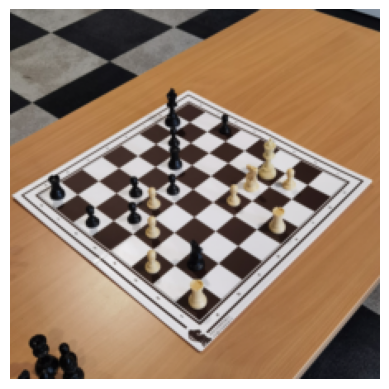

  3%|▎         | 4/134 [00:00<00:24,  5.28it/s]

Ground truth: 
['-', '-', '-', '-', '-', '-', '-', 'R']
['K', 'P', '-', '-', 'R', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', 'r', 'N', 'n', 'P', '-']
['-', '-', '-', '-', '-', 'P', 'p', '-']
['p', 'r', '-', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Prediction: 
['-', '-', '-', '-', '-', '-', '-', 'R']
['P', 'P', '-', '-', 'Q', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', 'P', 'P', 'B', 'P', '-']
['-', '-', '-', '-', '-', '-', 'p', '-']
['p', 'q', '-', '-', '-', 'r', '-', '-']
['-', 'p', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


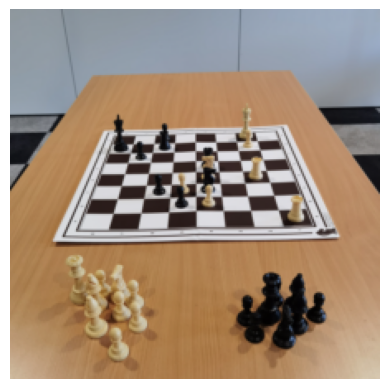

  4%|▎         | 5/134 [00:00<00:23,  5.51it/s]

Ground truth: 
['-', 'K', 'R', '-', '-', '-', '-', '-']
['-', 'P', '-', '-', 'R', '-', '-', '-']
['-', 'N', '-', '-', '-', '-', '-', '-']
['-', 'n', '-', '-', '-', '-', 'r', '-']
['-', '-', '-', '-', 'r', '-', 'p', '-']
['-', '-', '-', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Prediction: 
['-', 'K', 'R', '-', '-', '-', '-', '-']
['-', 'P', '-', '-', 'R', '-', '-', '-']
['-', 'P', '-', '-', '-', '-', '-', '-']
['-', 'n', '-', '-', '-', '-', 'B', '-']
['-', '-', '-', '-', 'p', '-', 'p', '-']
['-', '-', '-', '-', '-', 'p', '-', '-']
['k', 'p', 'k', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


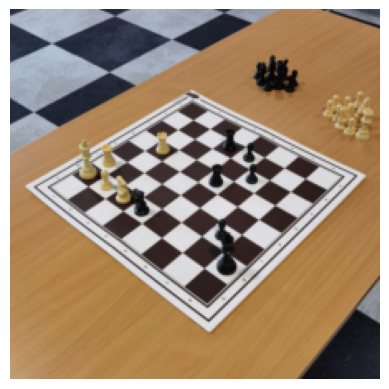

  4%|▎         | 5/134 [00:01<00:30,  4.30it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    tests = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            print("Ground truth: ")
            print_readable_board(y[0])
            print("Prediction: ")
            print_readable_board(pred[0].view( 8, 8, 13))
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            tests -= 1
            if tests < 0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?